In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyrender import IntrinsicsCamera, Mesh, Node, Scene, Viewer, OffscreenRenderer, DirectionalLight, SpotLight, PointLight, RenderFlags
from pathlib import Path
import json
import trimesh
import cv2


In [4]:
model_info = json.load(open('sample_data/models_simplified/models_info.json', 'r'))
from seaborn import color_palette
palette = color_palette('hls', 30)

In [5]:
# borrowed from https://github.com/hughw19/NOCS_CVPR2019/blob/master/utils.py
def get_3d_bbox(scale, shift = 0):
    """
    Input: 
        scale: [3] or scalar
        shift: [3] or scalar
    Return 
        bbox_3d: [3, N]
    """
    if hasattr(scale, "__iter__"):
        bbox_3d = np.array([[scale[0] / 2, +scale[1] / 2, scale[2] / 2],
                  [scale[0] / 2, +scale[1] / 2, -scale[2] / 2],
                  [-scale[0] / 2, +scale[1] / 2, scale[2] / 2],
                  [-scale[0] / 2, +scale[1] / 2, -scale[2] / 2],
                  [+scale[0] / 2, -scale[1] / 2, scale[2] / 2],
                  [+scale[0] / 2, -scale[1] / 2, -scale[2] / 2],
                  [-scale[0] / 2, -scale[1] / 2, scale[2] / 2],
                  [-scale[0] / 2, -scale[1] / 2, -scale[2] / 2]]) + shift
    else:
        bbox_3d = np.array([[scale / 2, +scale / 2, scale / 2],
                  [scale / 2, +scale / 2, -scale / 2],
                  [-scale / 2, +scale / 2, scale / 2],
                  [-scale / 2, +scale / 2, -scale / 2],
                  [+scale / 2, -scale / 2, scale / 2],
                  [+scale / 2, -scale / 2, -scale / 2],
                  [-scale / 2, -scale / 2, scale / 2],
                  [-scale / 2, -scale / 2, -scale / 2]]) +shift

    bbox_3d = bbox_3d.transpose()
    return bbox_3d


def draw(img, imgpts, axes, color):
    imgpts = np.int32(imgpts).reshape(-1, 2)


    # draw ground layer in darker color
    color_ground = (int(color[0]), int(color[1]), int(color[2]))
    for i, j in zip([4, 5, 6, 7],[5, 7, 4, 6]):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), color_ground, 3)


    # draw pillars in blue color
    color_pillar = (int(color[0]), int(color[1]), int(color[2]))
    for i, j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), color_pillar, 3)

    
    # finally, draw top layer in color
    for i, j in zip([0, 1, 2, 3],[1, 3, 0, 2]):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), color, 3)


    # draw axes
    img = cv2.line(img, tuple(axes[0]), tuple(axes[1]), (0, 0, 255), 3)  # z
    img = cv2.line(img, tuple(axes[0]), tuple(axes[3]), (255, 0, 0), 3)  # x
    img = cv2.line(img, tuple(axes[0]), tuple(axes[2]), (0, 255, 0), 3) ## y last


    return img


def transform_coordinates_3d(coordinates, RT):
    """
    Input: 
        coordinates: [3, N]
        RT: [4, 4]
    Return 
        new_coordinates: [3, N]
    """
    assert coordinates.shape[0] == 3
    coordinates = np.vstack([coordinates, np.ones((1, coordinates.shape[1]), dtype=np.float32)])
    new_coordinates = RT @ coordinates
    new_coordinates = new_coordinates[:3, :]/new_coordinates[3, :]
    return new_coordinates


def calculate_2d_projections(coordinates_3d, intrinsics):
    """
    Input: 
        coordinates: [3, N]
        intrinsics: [3, 3]
    Return 
        projected_coordinates: [N, 2]
    """
    projected_coordinates = intrinsics @ coordinates_3d
    projected_coordinates = projected_coordinates[:2, :] / projected_coordinates[2, :]
    projected_coordinates = projected_coordinates.transpose()
    projected_coordinates = np.array(projected_coordinates, dtype=np.int32)

    return projected_coordinates

def draw_pose(img, intrinsics, rot, center, scale, color=(255, 0, 0)):
    mat = np.eye(4)
    scale_norm = np.linalg.norm(scale)
    mat[:3, :3] = rot * scale_norm
    mat[:3, -1] = center
    
    xyz_axis = 0.3 * np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]).transpose()
    transformed_axes = transform_coordinates_3d(xyz_axis, mat)
    projected_axes = calculate_2d_projections(transformed_axes, intrinsics)

    bbox_3d = get_3d_bbox(scale / scale_norm, 0)
    transformed_bbox_3d = transform_coordinates_3d(bbox_3d, mat)
    projected_bbox = calculate_2d_projections(transformed_bbox_3d, intrinsics)
    draw_image_bbox = draw(img, projected_bbox, projected_axes, color)
    return draw_image_bbox

476
477
475
502
335
229
235


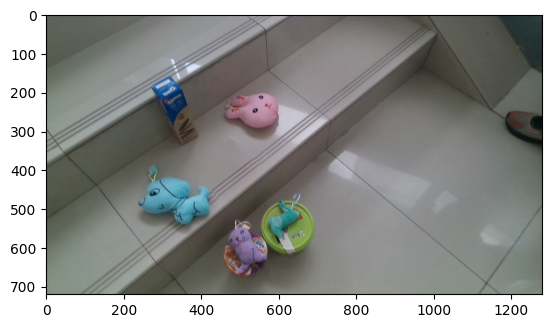

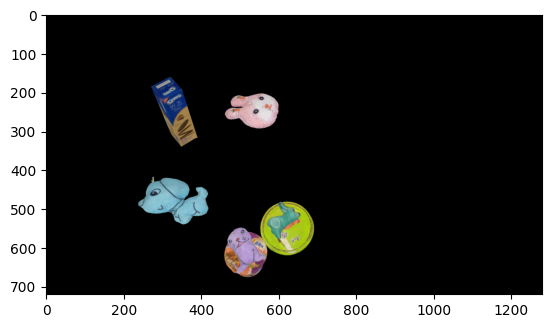

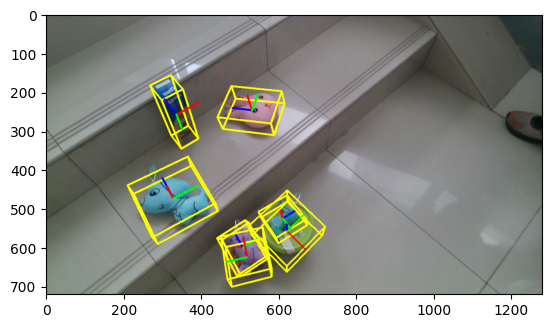

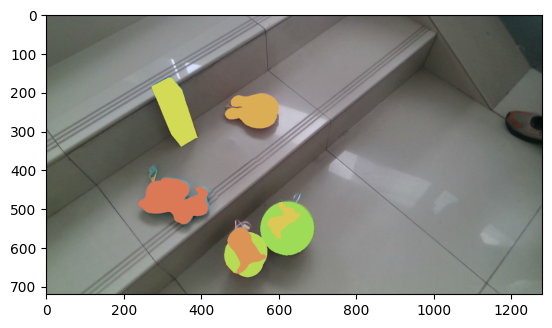

In [13]:
from tqdm.notebook import tqdm
from scipy import stats
root = 'sample_data'
scene_id = 90
split = 'val'
img_fns = list(Path(f'{root}/{split}/{scene_id:06d}/rgb/').glob('*.png'))
for img_id in sorted(img_fns):
    img_id = int(img_id.stem)
    r = OffscreenRenderer(viewport_width=1280, viewport_height=720)
    
    img = cv2.imread(f'{root}/{split}/{scene_id:06d}/rgb/{img_id:06d}.png')[..., ::-1]

    scene_gts = json.load(open(f'{root}/{split}/{scene_id:06d}/scene_gt.json'))
    scene_camera = json.load(open(f'{root}/{split}/{scene_id:06d}/scene_camera.json'))
    scene_gt = scene_gts[str(img_id)]
    intrinsic = np.array(scene_camera[str(img_id)]['cam_K']).reshape(3, 3)

    scene = Scene(ambient_light=np.array([1, 1, 1, 1.0]), bg_color=np.zeros((3,)))
    direc_l = DirectionalLight(color=np.ones(3), intensity=5)
    spot_l = SpotLight(color=np.ones(3), intensity=5, innerConeAngle=np.pi/16, outerConeAngle=np.pi/6)

    cam_pose = np.eye(4)
    cam = IntrinsicsCamera(intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2])
    scene.add(cam, pose=cam_pose)
    scene.add(direc_l, pose=cam_pose)
    scene.add(spot_l, pose=cam_pose)

    rots = []
    centers = []
    center_offsets = []
    scales = []
    for gt in scene_gt:
        obj_id = gt['obj_id']
        print(obj_id)
        R = np.array(gt['cam_R_m2c']).reshape(3, 3)
        t = np.array(gt['cam_t_m2c']) / 1000

        pose = np.eye(4)
        pose[:3, :3] = R
        pose[:3, 3] = t
        pose[1:3] *= -1

        mesh = trimesh.load(f'sample_data/models_simplified/obj_{obj_id:06d}.ply')
        mesh.apply_scale(1e-3)
        vertices = mesh.vertices
        bounds = np.stack([np.min(vertices, 0), np.max(vertices, 0)])
        center = bounds.mean(0)
        center_offsets.append(center)
        mesh.apply_transform(pose)
        
        scale = np.array([model_info[str(obj_id)]['size_x'], model_info[str(obj_id)]['size_y'], model_info[str(obj_id)]['size_z']]) / 1000.
        rots.append(R)
        centers.append(t)
        scales.append(scale)

        scene.add(Mesh.from_trimesh(mesh), pose=np.eye(4))
        
    plt.imshow(img)
    plt.show()
    
    rendered, depth = r.render(scene)
    nm = {node: (i + 1) for i, node in enumerate(scene.mesh_nodes)}
    seg = r.render(scene, RenderFlags.SEG, nm)[0][:, :, 0]
    r.delete()

    plt.imshow(rendered)
    plt.show()

    pose_vis = np.copy(img)
    for i in range(len(rots)):
        draw_pose(pose_vis, intrinsic, rots[i], centers[i] + rots[i] @ center_offsets[i], scales[i], color=(255, 255, 0))
        
    plt.imshow(pose_vis)
    plt.show()
    
    seg = np.zeros_like(rendered[..., 0])
    for i in range(len(rots)):
        mask = cv2.imread(f'sample_data/{split}/{scene_id:06d}/mask_visib/{img_id:06d}_{i:06d}.png', 0)
        seg[mask > 0] = i + 1
    
    seg_vis = np.copy(img)
    for i in range(1, seg.max() + 1):
        seg_vis[seg == i] = np.array(palette[i]) * 255
        
    plt.imshow(seg_vis)
    plt.show()
    
    cv2.imwrite(f'images/rgb_{img_id:06d}.png', img[..., ::-1])
    cv2.imwrite(f'images/render_{img_id:06d}.png', rendered[..., ::-1])
    cv2.imwrite(f'images/pose_{img_id:06d}.png', pose_vis[..., ::-1])
    cv2.imwrite(f'images/mask_{img_id:06d}.png', seg_vis[..., ::-1])